In [1]:
import pandas as pd

from ray import tune
from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast

In [2]:
def create_date_format(
        df: pd.DataFrame, original_date_column: str
    ) -> pd.DataFrame:
        """
        Creates a pandas datetime object from a date string.
        Very specifiy to the output of the mdb notebook yrmo column.
        """
        df["yyyymm"] = df[original_date_column].apply(
            lambda x: str(x)[:4] + "-" + str(x)[4:] + "-01"
        )
        df["yyyymm"] = pd.to_datetime(df.yyyymm)
        return df

In [3]:
df = pd.read_csv('s3://dsaa-cph-ai-s3-dev/jan_rathfelder/impact_data/fra_eylea_20230215.csv')
df = create_date_format(df, 'yrmo')

df_nixtla = df[['cstmr_1_id', 'yyyymm', 'sales_unit']]
df_nixtla.rename(columns={'cstmr_1_id': 'unique_id', 'yyyymm': 'ds', 'sales_unit': 'y'}, inplace=True)

In [4]:
df_nixtla.ds.min(), df_nixtla.ds.max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2022-11-01 00:00:00'))

The AutoNHITS class will automatically perform hyperparamter tunning using Tune library, exploring a user-defined or default search space. Models are selected based on the error on a validation set and the best model is then stored and used during inference.

In [5]:
horizon = 12 

# Use your own config or AutoNHITS.default_config
nhits_config = {
    "learning_rate": tune.loguniform(1e-4, 1e-2), # loguniform samples over log-space, which is common for learning rates.
    "max_steps": tune.randint(10, 50), # Random integer between 500 and 2000.
    "input_size": 1 * horizon, # if horizon is a variable and you want to just multiply it.
    "batch_size": tune.randint(1, 20),
    "windows_batch_size": tune.randint(100, 500),
    "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),
    "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]),
    "activation": "ReLU",
    "n_blocks": [1, 1, 1],
    "mlp_units": [[512, 512], [512, 512], [512, 512]],
    "interpolation_mode": "linear",
    "val_check_steps": 100,
    "random_seed": tune.randint(1, 10),
}


In [6]:
models = [AutoNHITS(h=horizon,
                    config=nhits_config, 
                    num_samples=5) # number of configurations explored
         ]

In [7]:
nf = NeuralForecast(
    models=models,
    freq='MS')

val_size  = 12 # 3 x 6 months
test_size = 12 # 1 x 6 months

Y_hat_df = nf.cross_validation(df=df_nixtla, 
                               val_size=val_size,
                               test_size=test_size, 
                               n_windows=None)

(_train_tune pid=16377) Seed set to 6


Epoch 0:  38%|███▊      | 15/40 [00:00<00:00, 47.21it/s, v_num=0, train_loss_step=12.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   8%|▊         | 3/40 [00:00<00:00, 152.94it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  52%|█████▎    | 21/40 [00:00<00:00, 166.24it/s]
(_train_tune pid=16377) 
Epoch 0:  38%|███▊      | 15/40 [00:00<00:00, 27.16it/s, v_num=0, train_loss_step=12.80, valid_loss=15.40, train_loss_epoch=24.50]


(_train_tune pid=16377) Seed set to 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  42%|████▏     | 36/85 [00:00<00:01, 39.24it/s, v_num=0, train_loss_step=7.650]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  20%|██        | 17/85 [00:00<00:00, 274.85it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  21%|██        | 18/85 [00:00<00:00, 274.73it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  54%|█████▍    | 46/85 [00:00<00:00, 276.15it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  55%|█████▌    | 47/85 [00:00<00:00, 276.16it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  56%|█████▋    | 48/85 [00:00<00:00, 275.81it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  58%|█████▊    | 49/85 [00:00<00:00, 275.46it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  67%|██████▋   | 57/85 [00:00<00:00, 175.65it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  68%|██████▊   | 58/85 [00:00<00:00, 176.63it/s]
(_train_tune pid=16377) 
Validation DataLoader 

(_train_tune pid=16377) Seed set to 7


Epoch 0:  31%|███       | 47/152 [00:00<00:01, 53.05it/s, v_num=0, train_loss_step=31.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  10%|▉         | 15/152 [00:00<00:00, 289.07it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  30%|██▉       | 45/152 [00:00<00:00, 291.43it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  30%|███       | 46/152 [00:00<00:00, 291.44it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  50%|█████     | 76/152 [00:00<00:00, 292.11it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  51%|█████     | 77/152 [00:00<00:00, 292.16it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  51%|█████▏    | 78/152 [00:00<00:00, 292.03it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  71%|███████   | 108/152 [00:00<00:00, 292.38it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  72%|███████▏  | 109/152 [00:00<00:00, 292.41it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  72%|███████▏  | 110/152 [00:00<00:00

(_train_tune pid=16377) Seed set to 8


(_train_tune pid=16377) 
Epoch 0:  98%|█████████▊| 47/48 [00:01<00:00, 37.75it/s, v_num=0, train_loss_step=19.10]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  38%|███▊      | 18/48 [00:00<00:00, 221.79it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  90%|████████▉ | 43/48 [00:00<00:00, 233.71it/s]
(_train_tune pid=16377) 
Epoch 0:  98%|█████████▊| 47/48 [00:01<00:00, 32.19it/s, v_num=0, train_loss_step=19.10, valid_loss=19.30, train_loss_epoch=30.30]


(_train_tune pid=16377) Seed set to 3


Epoch 0:  16%|█▋        | 14/85 [00:00<00:01, 56.00it/s, v_num=0, train_loss_step=27.30]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   9%|▉         | 8/85 [00:00<00:00, 247.93it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  11%|█         | 9/85 [00:00<00:00, 248.03it/s]
(_train_tune pid=16377) 
Validation DataLoader 0:  41%|████      | 35/85 [00:00<00:00, 249.24it/s]


Seed set to 2


(_train_tune pid=16377) 
Validation DataLoader 0:  72%|███████▏  | 61/85 [00:00<00:00, 249.80it/s]
(_train_tune pid=16377) 
Epoch 0:  16%|█▋        | 14/85 [00:00<00:03, 23.29it/s, v_num=0, train_loss_step=27.30, valid_loss=18.30, train_loss_epoch=28.80]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [8]:
nf.models[0].results.get_best_result().config

{'learning_rate': 0.0010367262695052614,
 'max_steps': 36,
 'input_size': 12,
 'batch_size': 9,
 'windows_batch_size': 419,
 'n_pool_kernel_size': [2, 2, 2],
 'n_freq_downsample': [168, 24, 1],
 'activation': 'ReLU',
 'n_blocks': [1, 1, 1],
 'mlp_units': [[512, 512], [512, 512], [512, 512]],
 'interpolation_mode': 'linear',
 'val_check_steps': 100,
 'random_seed': 2,
 'h': 12,
 'loss': MAE(),
 'valid_loss': MAE()}

In [9]:
y_true = Y_hat_df.y.values
y_hat = Y_hat_df['AutoNHITS'].values

n_series = len(df_nixtla.unique_id.unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)

print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)

Parsed results
2. y_true.shape (n_series, n_windows, n_time_out):	 (757, 1, 12)
2. y_hat.shape  (n_series, n_windows, n_time_out):	 (757, 1, 12)


In [10]:
y_true[2,0], y_hat[2,0]

(array([108.64312, 102.37527, 100.49487, 108.39726,  86.63121, 103.17898,
        116.39654,  98.15518, 101.40378, 124.75819, 100.79751, 128.72893]),
 array([101.13281 , 103.89331 , 105.88607 , 107.692215, 117.50697 ,
        121.15292 , 127.63724 , 121.144165, 119.84822 , 116.99919 ,
        122.86066 , 106.07917 ], dtype=float32))

In [11]:
from neuralforecast.losses.numpy import mae, mse, smape, mape

print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))
print('mape: ', mape(y_hat, y_true))
print('smape: ', smape(y_hat, y_true))

MAE:  15.164537717114463
MSE:  800.6629416109752
mape:  11.450381691001018
smape:  0.5677993769886875


$\text{MAPE} = \frac{100\%}{n} \sum \frac{|F_t - A_t|}{|A_t|}$

$\text{SMAPE} = \frac{100\%}{n} \sum \frac{|F_t - A_t|}{(|A_t| + |F_t|)/2}$

$F_{t}=$ forecast at point $t$

$A_{t}=$ actual at point $t$

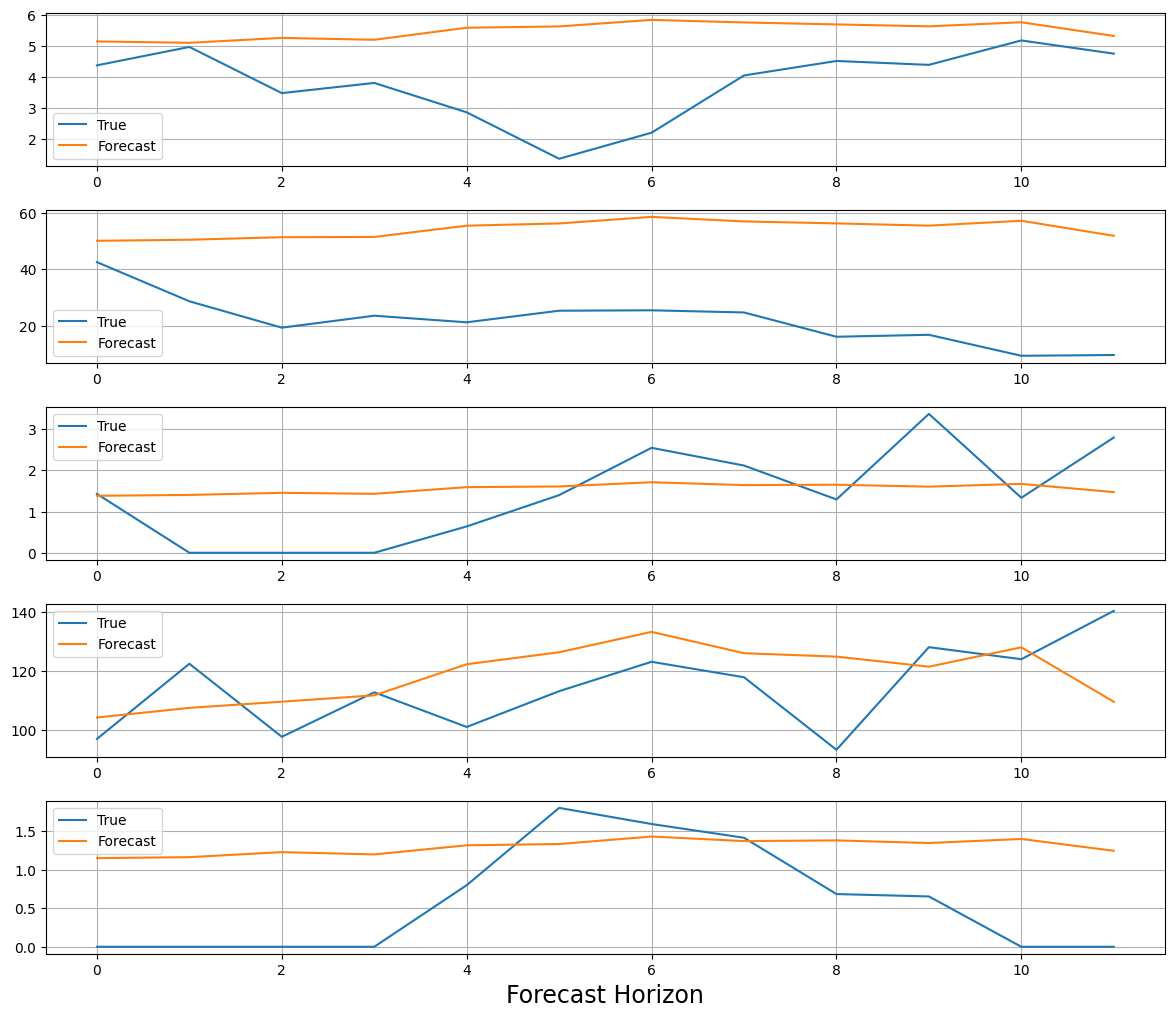

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 10))
fig.tight_layout()

for idx, w_idx in enumerate(np.random.choice(len(y_hat), 5, replace=False)):
    axs[idx].plot(y_true[w_idx, 0,:],label='True')
    axs[idx].plot(y_hat[w_idx, 0,:],label='Forecast')
    axs[idx].grid()
    if idx==4:
        axs[idx].set_xlabel('Forecast Horizon', fontsize=17)
    axs[idx].legend()

plt.show()
plt.close()